In [1]:
#let's calculate the average time step length of our dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [204]:
from utils import data_reading, music_generation
from models import music_generation_gru
import os
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from models.music_classification_cnn import MusicClassificationCNN
from dataset.iterable_classification_dataset import IterableClassificationSongDataset
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from utils.training_cnn import training_cnn, evaluate_cnn
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
PROJECT_DIR ="D:/522 project"
PPR_DIR = "lpd_5_pianoroll"
SAVE_DIR = "./gru_unnormalized_piano/music"
PATH = os.path.join(PROJECT_DIR, PPR_DIR)
INSTRUMENTS = ["Piano", "Drums", "Bass"]
RESOLUTION = 12
TRAIN_SPLIT = 0.8
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TOTAL_FILES = 10000

In [205]:
all_file_paths = data_reading.read_all_npzs(PATH, True)
all_file_paths = all_file_paths[:TOTAL_FILES]
train_file_paths = all_file_paths[:round(len(all_file_paths)*TRAIN_SPLIT)]
test_file_paths = all_file_paths[round(len(all_file_paths)*TRAIN_SPLIT):]

In [206]:
pprs = data_reading.read_and_preprocess_pianorolls(train_file_paths[:1000], 48, RESOLUTION, False)

In [207]:
total_length = 0
for pianoroll in pprs:
    total_length+=pianoroll.get_max_length()
average_length = total_length/len(pprs)
print(average_length)
WINDOW_LENGTH = 5000

4945.968


In [208]:
LABEL_DIR = "D:/522 project/lpd_5/amg"
label_df = data_reading.read_label_tagtraum(LABEL_DIR)
LPD_MSD = "D:/522 project/lpd_5/cleansed_ids.txt"
lpd_msd_df = data_reading.read_lpd_to_msd_df(LPD_MSD)
lpd_msd_label_df = label_df.merge(lpd_msd_df, left_on="id", right_on="msd_id", how="left")
lpd_msd_label_df = lpd_msd_label_df.set_index("lpd_id")
#merge folk country, blues jazz reggae, 
lpd_label_df = lpd_msd_label_df.drop(columns=["id", "msd_id"])
lpd_label_df.loc[lpd_label_df["genre"] == "Folk", "genre"] = "Country"
lpd_label_df.loc[lpd_label_df["genre"] == "Blues", "genre"] = "Jazz"
lpd_label_df.loc[lpd_label_df["genre"] == "Reggae", "genre"] = "Jazz"
lpd_label_df["genre"].value_counts()

D:\upenn\upenn\spring 2022\cis522\project_code\utils\data_reading.py:143: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return pd.read_csv(path, sep="    ", names=["lpd_id", "msd_id"])


Rock             4345
Electronic        889
Country           557
RnB               397
Latin             360
Jazz              224
International     206
Rap               164
Vocal             114
New-Age            67
Name: genre, dtype: int64

In [209]:
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(lpd_label_df["genre"])

In [210]:
label_encoder.classes_

array(['Country', 'Electronic', 'International', 'Jazz', 'Latin',
       'New-Age', 'Rap', 'RnB', 'Rock', 'Vocal'], dtype=object)

In [211]:
lpd_label_df["label"] = label

In [212]:
class_weight = []
for x in label_encoder.classes_:
    class_weight.append(len(lpd_label_df)/ lpd_label_df["genre"].value_counts()[x])

In [213]:
label_encoder.classes_

array(['Country', 'Electronic', 'International', 'Jazz', 'Latin',
       'New-Age', 'Rap', 'RnB', 'Rock', 'Vocal'], dtype=object)

In [214]:
class_weight

[13.14721723518851,
 8.23734533183352,
 35.54854368932039,
 32.691964285714285,
 20.341666666666665,
 109.29850746268657,
 44.65243902439025,
 18.445843828715365,
 1.685385500575374,
 64.23684210526316]

In [219]:
train_pprs = data_reading.read_and_preprocess_and_filter_pianorolls2(train_file_paths, 
                                                                     INSTRUMENTS, WINDOW_LENGTH, 
                                                                     RESOLUTION, lpd_label_df.index, False)

0
1000
2000
3000
4000
5000
6000
7000


In [220]:
test_pprs = data_reading.read_and_preprocess_and_filter_pianorolls2(test_file_paths, 
                                                                     INSTRUMENTS, WINDOW_LENGTH, 
                                                                     RESOLUTION, lpd_label_df.index, False)

0
1000


In [221]:
train_piano_dataset = IterableClassificationSongDataset(train_pprs, WINDOW_LENGTH, RESOLUTION, INSTRUMENTS, lpd_label_df)
train_piano_loader = DataLoader(train_piano_dataset, batch_size = BATCH_SIZE, drop_last=True)
test_piano_dataset =  IterableClassificationSongDataset(test_pprs, WINDOW_LENGTH, RESOLUTION, INSTRUMENTS, lpd_label_df)
test_piano_loader = DataLoader(test_piano_dataset, batch_size = BATCH_SIZE, drop_last=True)

In [283]:
model = MusicClassificationCNN(train_piano_dataset.get_track_order(), len(class_weight), False).to(DEVICE)

In [284]:
criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor(class_weight).float().to(DEVICE))

In [285]:
LR = 0.0001
LR_LAMBDA = 1
AUTOSAVE = True
SAVE_ON_EPOCH = 5
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda epoch: LR_LAMBDA ** epoch)

In [297]:
N_EPOCH = 20
train_losses, test_losses = training_cnn(model, optimizer, scheduler, criterion, train_piano_loader, test_piano_loader,
            N_EPOCH, DEVICE, AUTOSAVE, SAVE_ON_EPOCH)

[0.0001]
start test
Epoch 1, Train Loss: 1.0947478644549846, Test Loss: 1.7590455632460744, Time: 2022-04-28 10:17:16.763405
[0.0001]
start test
Epoch 2, Train Loss: 1.061156352609396, Test Loss: 1.720272892399838, Time: 2022-04-28 10:17:29.967403
[0.0001]
start test
Epoch 3, Train Loss: 0.9574900608509779, Test Loss: 1.7478911186519421, Time: 2022-04-28 10:17:43.030905
[0.0001]
start test
Epoch 4, Train Loss: 0.9390643902122975, Test Loss: 1.75195176350443, Time: 2022-04-28 10:17:55.874403
[0.0001]
start test
Epoch 5, Train Loss: 0.8929886408150196, Test Loss: 1.787351746308176, Time: 2022-04-28 10:18:09.128403
[0.0001]
start test
Epoch 6, Train Loss: 0.8605557806789875, Test Loss: 1.7956600565659373, Time: 2022-04-28 10:18:22.116902
[0.0001]
start test
Epoch 7, Train Loss: 0.8017205085605383, Test Loss: 1.8050303208200555, Time: 2022-04-28 10:18:35.025403
[0.0001]
start test
Epoch 8, Train Loss: 0.7909659527242183, Test Loss: 1.7745615243911743, Time: 2022-04-28 10:18:47.754403
[0.00

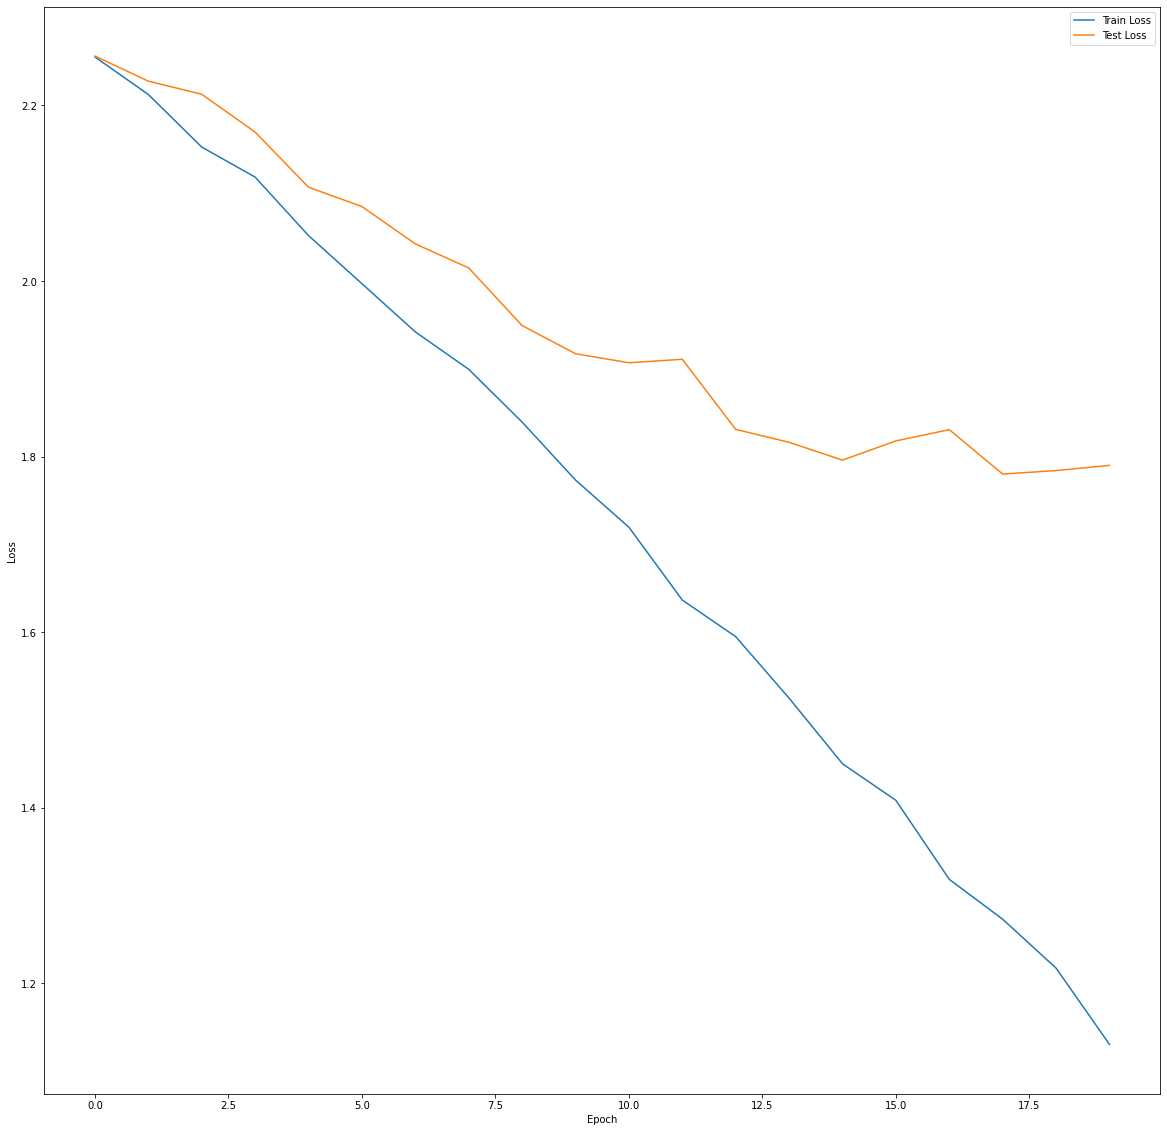

In [288]:
plt.rcParams["figure.figsize"] = (20,20)
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [298]:
pred_y, true_y = evaluate_cnn(model, test_piano_loader, DEVICE)

In [299]:
pred_y = np.concatenate(pred_y)
true_y = np.concatenate(true_y)

In [300]:
pred_label = label_encoder.inverse_transform(pred_y)
true_label = label_encoder.inverse_transform(true_y)

In [301]:
pred_label

array(['Electronic', 'Country', 'Country', 'Latin', 'Country',
       'Electronic', 'RnB', 'Country', 'Country', 'Latin', 'Country',
       'Electronic', 'Latin', 'Country', 'Electronic', 'Jazz', 'Rap',
       'International', 'Electronic', 'Rap', 'Vocal', 'Electronic', 'Rap',
       'Country', 'International', 'New-Age', 'Electronic', 'RnB', 'Rap',
       'Electronic', 'Country', 'Rock', 'Country', 'Electronic',
       'Country', 'Country', 'Rap', 'RnB', 'International', 'Country',
       'Rock', 'Jazz', 'Latin', 'Country', 'Jazz', 'Country', 'Country',
       'Latin', 'Electronic', 'Rap', 'Latin', 'Electronic',
       'International', 'Country', 'Country', 'Rap', 'Rock', 'Jazz',
       'Electronic', 'Vocal', 'Electronic', 'Latin', 'Country',
       'Electronic', 'RnB', 'Electronic', 'Electronic', 'Electronic',
       'Country', 'Electronic', 'International', 'Electronic', 'RnB',
       'Country', 'Country', 'Rap', 'Jazz', 'Electronic', 'Latin',
       'Electronic', 'RnB', 'Country', 

In [302]:
cm = confusion_matrix(true_y, pred_y)

In [303]:
from sklearn.metrics import ConfusionMatrixDisplay

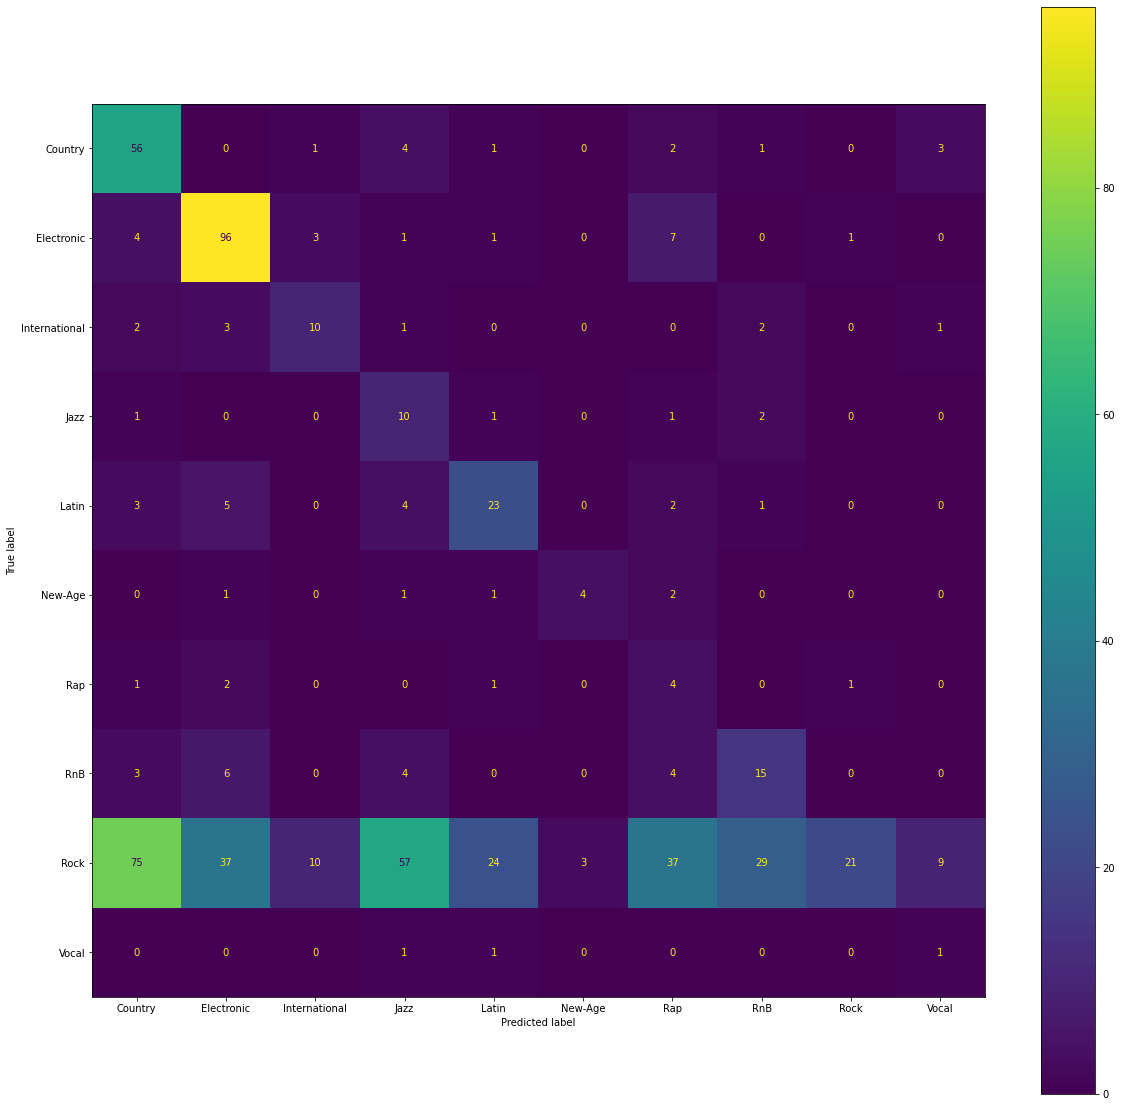

In [304]:
cmd = ConfusionMatrixDisplay(cm, display_labels = label_encoder.classes_)
cmd.plot()

In [272]:
pred_y

array([1, 8, 8, 0, 0, 1, 8, 0, 7, 4, 0, 8, 4, 8, 1, 8, 1, 8, 1, 8, 8, 8,
       8, 0, 8, 8, 1, 8, 8, 8, 0, 8, 0, 1, 0, 8, 8, 4, 1, 0, 8, 8, 4, 8,
       0, 8, 8, 4, 2, 8, 8, 8, 7, 1, 0, 6, 0, 1, 1, 8, 1, 8, 8, 1, 8, 1,
       1, 1, 8, 8, 2, 1, 0, 2, 8, 3, 8, 1, 4, 8, 8, 0, 8, 8, 3, 8, 8, 8,
       0, 8, 8, 1, 0, 8, 6, 0, 8, 8, 8, 8, 4, 8, 8, 0, 2, 8, 8, 0, 8, 8,
       7, 1, 8, 8, 0, 3, 1, 1, 8, 0, 8, 1, 8, 1, 8, 8, 8, 8, 8, 0, 8, 8,
       1, 4, 8, 8, 8, 0, 0, 0, 8, 8, 0, 3, 8, 1, 8, 1, 8, 4, 0, 8, 8, 1,
       4, 8, 0, 8, 7, 4, 8, 0, 8, 8, 8, 2, 8, 3, 8, 7, 1, 8, 0, 0, 6, 1,
       8, 0, 1, 8, 1, 8, 8, 8, 2, 0, 1, 1, 0, 7, 1, 0, 8, 7, 1, 8, 1, 8,
       0, 8, 8, 8, 0, 1, 8, 8, 8, 8, 8, 1, 8, 9, 8, 4, 7, 0, 8, 1, 8, 8,
       0, 1, 3, 8, 8, 0, 4, 8, 0, 8, 1, 8, 8, 8, 8, 8, 1, 8, 8, 2, 8, 8,
       8, 1, 1, 0, 4, 8, 8, 1, 1, 1, 4, 0, 0, 8, 0, 8, 8, 8, 0, 8, 1, 8,
       6, 1, 8, 7, 0, 8, 8, 8, 0, 0, 1, 0, 0, 1, 4, 1, 0, 8, 0, 7, 8, 8,
       4, 0, 1, 4, 0, 8, 1, 8, 8, 8, 8, 8, 1, 1, 8,

In [273]:
true_y

array([1, 8, 8, 0, 8, 1, 8, 8, 8, 4, 0, 8, 8, 8, 1, 8, 8, 8, 1, 8, 8, 8,
       8, 0, 8, 8, 1, 8, 8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 1, 3, 8, 8, 4, 2,
       0, 8, 8, 4, 8, 8, 4, 8, 8, 8, 8, 6, 8, 1, 1, 8, 1, 8, 8, 1, 3, 1,
       1, 1, 8, 1, 8, 8, 8, 8, 8, 4, 8, 1, 8, 8, 8, 0, 8, 8, 3, 8, 8, 8,
       0, 7, 8, 7, 0, 8, 8, 5, 8, 7, 5, 8, 4, 7, 8, 0, 2, 8, 8, 0, 1, 8,
       1, 1, 8, 8, 0, 3, 1, 1, 8, 8, 1, 1, 8, 8, 7, 2, 1, 0, 8, 8, 8, 8,
       8, 4, 8, 8, 7, 8, 8, 0, 8, 2, 8, 3, 0, 1, 8, 1, 8, 8, 0, 8, 7, 1,
       8, 8, 0, 8, 8, 4, 8, 0, 0, 8, 8, 7, 6, 7, 6, 7, 8, 8, 0, 0, 8, 1,
       8, 8, 1, 8, 8, 0, 8, 9, 2, 8, 8, 1, 0, 7, 1, 0, 4, 7, 1, 8, 1, 8,
       8, 8, 8, 8, 8, 1, 8, 8, 8, 8, 1, 1, 8, 9, 8, 4, 4, 0, 8, 1, 8, 0,
       0, 1, 8, 8, 8, 4, 0, 2, 7, 7, 1, 8, 8, 8, 8, 8, 1, 8, 8, 2, 8, 8,
       8, 8, 1, 8, 8, 8, 8, 1, 1, 8, 4, 0, 0, 8, 0, 8, 8, 8, 8, 8, 1, 8,
       8, 1, 8, 7, 0, 8, 0, 8, 0, 5, 1, 0, 8, 4, 8, 1, 0, 8, 0, 7, 8, 8,
       4, 4, 8, 6, 0, 8, 1, 8, 2, 8, 0, 8, 1, 1, 8,

In [305]:
(pred_y==true_y).mean()

0.39473684210526316

In [253]:
cm

array([[284,   0,   3,   1,   2,   0,   2,   1,   0,   0],
       [  4, 479,   0,   2,   1,   0,   0,   1,   2,   0],
       [  0,   0,  82,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  84,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0, 151,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  20,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  29,   0,   0,   0],
       [  0,   0,   0,   0,   0,   2,   0, 156,   0,   0],
       [179,  67,  32,  11,  43,   2,  15,  71, 799,   5],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  29]], dtype=int64)

In [112]:
torch.save(model.state_dict(), "./non_linear_classifier_cnn")